# Image Captioning API Demo
Hereby notebook presents the API of image captioning system created by me. It shows the model pipeline and demonstrates neccessary methods utlizied during program workflow. 

In [1]:
import os
import pickle
import numpy as np
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pylab
import json
import random
import math

from pycocotools.coco import COCO

from image_captioning.data import data_processing
from image_captioning.model_manager import Model

#pylab.rcParams['figure.figsize'] = (8.0, 10.0)

It is very computational demanding process, thus I decided to store all computed values and just reload them. Change the bool values if you want to try the model on our own.

In [2]:
have_dataset = True
pretrained = True
evaluated = True

# Hiperparemeters

In [34]:
batch_size = 64
top_k = 5000
epochs = 20

train_samples = 30000
train_samples = train_samples - (train_samples % batch_size)

val_samples = 10000
val_samples = val_samples - (val_samples % batch_size)
print('Train sample: {}, validation samples: {}'.format(train_samples, val_samples))

Train sample: 29952, validation samples: 9984


# Dataset

Get dataset.

In [4]:
if not have_dataset:
    ! ./image_captioning/coco/getdataset.sh

# Prepare dataset repository

In [5]:
if not os.path.exists('image_captioning/data/repository.pkl'):
    print('Preparing repository.')
    repo = data_processing.prepare_repository(train_samples, val_samples, top_k)

    with open('./image_captioning/data/repository.pkl', 'w+b') as file:
        pickle.dump(repo, file)

    print('Repository is ready!')

# Repository contents examples

Each caption was padded to be the same lenght, which is given by max_length parameter.

In [6]:
with open('./image_captioning/data/repository.pkl', 'rb') as handle:
    repository = pickle.load(handle)

features_path_list = repository['train_feature_path_list']
caption_list = repository['train_caption_list']
tokenizer = repository['tokenizer']
max_length = repository['max_length']
print("feature_path_list sample: {}\n".format(features_path_list[0]))
print("Caption indexes sample:\n {}\n".format(caption_list[0]))
caption_words = [tokenizer.index_word[i] for i in caption_list[0]]
print("Caption words sample:\n {}\n".format(caption_words))                              
print("max_length: {}\n".format(max_length))
print("Word count of 'a': {}\n".format(tokenizer.word_counts['a']))
print("Word index of 'be': {}\n".format(tokenizer.word_index['be']))
print("Max number of words: {}, word index len: {}".format(tokenizer.num_words, len(tokenizer.word_index)))

feature_path_list sample: coco/train2014_features/COCO_train2014_000000560459.jpg.npy

Caption indexes sample:
 [  3   2 483 173 142  73  14  94  91   4   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]

Caption words sample:
 ['<start>', 'a', 'jetliner', 'taking', 'off', 'from', 'an', 'airport', 'runway', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']

max_length: 48

Word count of 'a': 49572

Word index of 'be': 280

Max number of words: 5000, word index len: 7413


# Prepare model

In [7]:
model = Model(top_k, batch_size)

# Train
Image captioning  is very computational demanding task, so Tensorflow checkpoints are utlized. Checpoints are stoing informations about given tensorflow objects:

* encoder
* optimizer
* decoder

This allows to break training in any moment, then return to trained models. Checpoint system is allso used in case of validation and evalutation images, it allows to use previousl pre-trained models. Checkpoint are saved in `image_captioning/training_checkpoints/` directory.

In [8]:
if not pretrained:
    model.train(train_samples, epochs)

# Loss plot

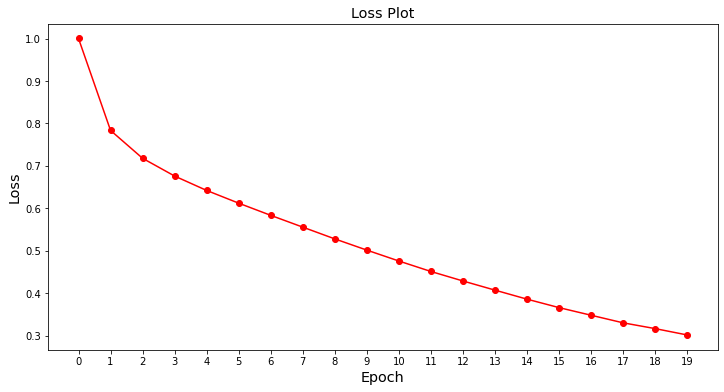

In [9]:
with open('results/training/loss.json', 'r') as handle:
    loss_plot = json.load(handle)

plt.figure(figsize=(12,6))
plt.plot(loss_plot, 'r-o')
plt.xlabel('Epoch', fontsize='x-large')
plt.ylabel('Loss', fontsize='x-large')
plt.title('Loss Plot', fontsize='x-large')
plt.xticks([i for i in range(epochs)])
plt.savefig('results/training/loss_plot.png', bbox_inches='tight')

# Sample image evaluation

This examples helps to verify wheter the model is working correctly. For each prediction decoder returns attention weights, which allows to contruct a attention plot. The attention plot shows, how the model predicted each word based on the image fragment. 

In [14]:
img = 'coco/val2014/COCO_val2014_000000261292.jpg'
img_id = 261292
temp_image = np.array(Image.open(img))

In [ ]:
model.evaluate(img, data_processing.prepare_feature_extractor())

## Attention plot

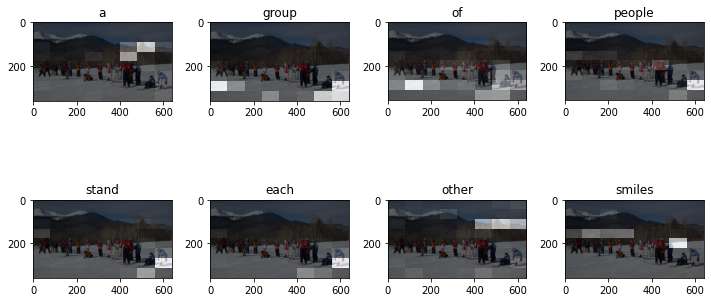

In [15]:
with open('./results/validation/attention_plot-183351.pkl', 'rb') as handle:
    attention_plot = pickle.load(handle)

with open('./results/validation/prediction-183351.pkl', 'rb') as handle:
    result = pickle.load(handle)

fig = plt.figure(figsize=(10, 10))

len_result = len(result)
for l in range(len_result):
    temp_att = np.resize(attention_plot[l], (8, 8))
    ax = fig.add_subplot(len_result//2, len_result//2, l+1)
    ax.set_title(result[l])
    img = ax.imshow(temp_image)
    ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

plt.tight_layout()
plt.show()

## COCO API
Further parts of code utlize offical COCO API. Please install locally pycocotools by clonning given repo:

git clone https://github.com/cocodataset/cocoapi.git

To install fallow the setup instruction for Python.

In [16]:
dataDir='./coco/ann2014'
dataType='val2014'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

In [17]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=6.61s)
creating index...
index created!


In [18]:
# initialize COCO api for caption annotations
annFile = '{}/annotations/captions_{}.json'.format(dataDir,dataType)
coco_caps=COCO(annFile)

loading annotations into memory...
Done (t=0.64s)
creating index...
index created!


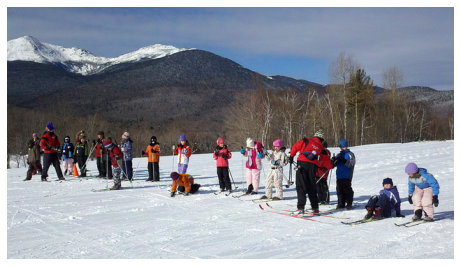

True captions:
A line of people in ski gear prepare to ski.
A group of children and adults in skis are standing on a snowy hill.
The group of people are standing while wearing skis and ski poles. 
A group of people in gear standing in the snow.
a group of people lined up  in the snow standing on some skis

Predicted caption:
 a group of people stand each other smiles



In [19]:
# load and display caption annotations
annIds = coco_caps.getAnnIds(img_id)
anns = coco_caps.loadAnns(annIds)
plt.imshow(temp_image); plt.axis('off'); plt.show()
print("True captions:")
coco_caps.showAnns(anns)
print("\nPredicted caption:\n {}\n".format(' '.join(result)))

# Validation

This part is to evaluate pre-trained model. The results of validation are stored in results/validation/captions_val2014.json file.

In [ ]:
if not validated:
    model.validate(val_samples)

## Evaluation

The evaluation is done by Microsoft COCO Caption Evaluation, https://github.com/tylin/coco-caption. I have done it befoer, so now I am loading the evaluation results.

In [2]:
with open('results/validation/captions_val2014_eval.json', 'r') as file:
    cocoEval = json.load(file)

for metric, score in cocoEval.items():
    print('{}: {}'.format(metric, score))

CIDEr: 0.225
Bleu_4: 0.061
Bleu_3: 0.118
Bleu_2: 0.226
Bleu_1: 0.411
ROUGE_L: 0.315
METEOR: 0.134
SPICE: 0.077


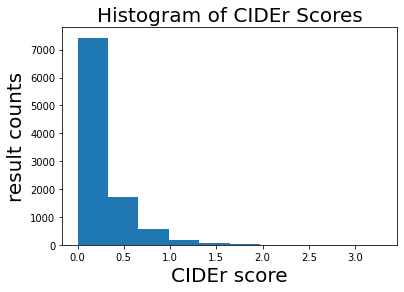

In [3]:
with open('results/validation/captions_val2014_evalImgs.json', 'r') as file:
    cocoEvalImgs = json.load(file)

# plot score histogram
ciderScores = [eva['CIDEr'] for eva in cocoEvalImgs]
plt.hist(ciderScores)
plt.title('Histogram of CIDEr Scores', fontsize=20)
plt.xlabel('CIDEr score', fontsize=20)
plt.ylabel('result counts', fontsize=20)
plt.show()

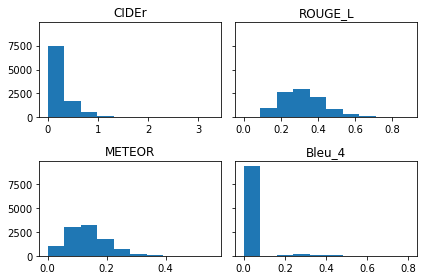

In [13]:
ciderScores = [eva['CIDEr'] for eva in cocoEvalImgs]
rougeScores = [eva['ROUGE_L'] for eva in cocoEvalImgs]
meteorScores = [eva['METEOR'] for eva in cocoEvalImgs]
bleuScores = [eva['Bleu_4'] for eva in cocoEvalImgs]


fig, axs = plt.subplots(2, 2, sharey=True, tight_layout=True)

axs[0][0].set_title('CIDEr')
axs[0][0].hist(ciderScores)

axs[0][1].set_title('ROUGE_L')
axs[0][1].hist(rougeScores)

axs[1][0].set_title('METEOR')
axs[1][0].hist(meteorScores)

axs[1][1].set_title('Bleu_4')
axs[1][1].hist(bleuScores)

plt.show()